# Digits recognition with supervised ML algorithms
### Using "classical" ML algorithms to recognise hand-written digits. 


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict,  cross_val_score
from sklearn.metrics import accuracy_score



# Downloading and analyzing data

In [7]:
#importing MNIST dataset with handwritten digits 

# from sklearn.datasets import fetch_openml
# df = fetch_openml("mnist_784", version=1)

# downloading mnist data every time is ineffective, saving them once as a file then reading them is much faster

# with open("data.pickle", "wb") as f:
#     pickle.dump(df, f)

In [8]:
#loading data
with open("data.pickle", "rb") as f:
    df = pickle.load(f)

In [9]:
#dividing dataset into data and target datasets
X, y = np.array(df["data"]), np.array(df["target"])
X.shape, y.shape

((70000, 784), (70000,))

In [10]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [12]:
#y data are str type, let's transform it
print(type(y[0]))
y = y.astype("uint8")
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


In [13]:
#distribution of the number of digits in a data set
for number in range(10):
    print(f"{number}: {len(y[y==number])/len(y) * 100: .3f}%")
#it seems that dataset is not very skewed, that's good :)

0:  9.861%
1:  11.253%
2:  9.986%
3:  10.201%
4:  9.749%
5:  9.019%
6:  9.823%
7:  10.419%
8:  9.750%
9:  9.940%


In [14]:
#checking if there are nan values
print(np.isnan(X).sum())
print(np.isnan(y).sum())

0
0


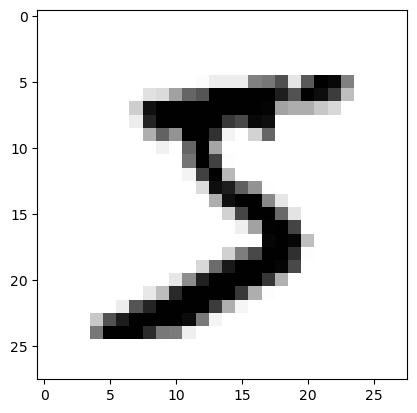

In [15]:
#showing sample image of number
plt.imshow(X[0].reshape(28,28), cmap = "binary")
plt.show()

In [16]:
#splitting datasets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1/7, random_state=42)

# Building model

In [31]:
#at first it would be a good idea to find the most promising model
dt_clf = DecisionTreeClassifier(max_depth=12)
print("dt model accuracy:", cross_val_score(dt_clf, X_train, y_train, cv=3, scoring="accuracy"))

dt model accuracy: [0.86315 0.86585 0.8578 ]


In [29]:
sgd_clf = SGDClassifier()
print("sgd model accuracy:", cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))

sgd model accuracy: [0.86495 0.87165 0.88415]


In [32]:
rfg_clf = RandomForestClassifier(max_depth=6)
print("rfg model accuracy:", cross_val_score(rfg_clf, X_train, y_train, cv=3, scoring="accuracy"))

rfg model accuracy: [0.89135 0.8877  0.88755]


In [42]:
#the Random Forest Classifier model seems to be the most promising, let's tune the hyperparameters
#building pipeline 
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier()),
])

params = [
    {
        "scaler": [StandardScaler()],
        "classifier__max_depth": [16,17,18]
    }
]

grid = GridSearchCV(pipeline, params, cv=3, scoring = "accuracy", n_jobs=-1)

In [43]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier__max_depth': [16, 17, 18],
                          'scaler': [StandardScaler()]}],
             scoring='accuracy')

In [44]:
evaluation = pd.DataFrame(data=grid.cv_results_)
evaluation

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,85.226133,1.755478,2.244845,0.338629,16,StandardScaler(),"{'classifier__max_depth': 16, 'scaler': Standa...",0.96490,0.96525,0.96380,0.964650,0.000618,2
1,83.926464,0.683637,2.457668,0.074342,17,StandardScaler(),"{'classifier__max_depth': 17, 'scaler': Standa...",0.96370,0.96580,0.96355,0.964350,0.001027,3
2,66.672933,29.252716,1.477516,0.586085,18,StandardScaler(),"{'classifier__max_depth': 18, 'scaler': Standa...",0.96475,0.96560,0.96410,0.964817,0.000614,1


In [45]:
# after a long time of calculations the best hyperparameters are as follows:
print(f"best estimator: {grid.best_estimator_}")
print(f"best params: {grid.best_params_}")
print(f"best accuracy: {grid.best_score_: .3f}%")


best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(max_depth=18))])
best params: {'classifier__max_depth': 18, 'scaler': StandardScaler()}
best accuracy:  0.965%


In [46]:
# training the final model on the entire data set
model = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(max_depth=16)), #we used max_depth=16 insted of 18 to avoid overfitting
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(max_depth=16))])

In [50]:
# applying the model to the test set and see the accuracy of final model
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print(f"accuracy: {accuracy_score(y_test, y_pred)}%")


accuracy: 0.9654%


In [51]:
#saving model
with open("supervised_model.pickle", "wb") as f:
    pickle.dump(model, f)